In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAALKQEIAALKKEAAALKWEIAALKQGYY', 'GEIAALKQEIAALKKEAAALKWEIAALKQGYY']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 5.0, 200, 154.2, 10]


### Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	70   	-869.326	28.0084	-927.959	-809.996
1  	72   	-885.967	18.5721	-927.959	-850.619
2  	60   	-896.162	15.7484	-927.959	-870.915
3  	69   	-905.333	12.9066	-930.823	-882.978
4  	69   	-911.368	9.70337	-935.046	-892.717
5  	58   	-916.116	7.91742	-939.191	-903.571
6  	69   	-922.286	7.46272	-939.191	-911.5  
7  	74   	-928.39 	6.44344	-942.993	-916.922
8  	56   	-934.004	4.50613	-948.018	-924.528
9  	72   	-939.442	4.78791	-951.437	-932.826
10 	73   	-944.643	4.27153	-951.437	-936.236
11 	66   	-948.752	2.36747	-953.109	-943.306
12 	75   	-950.759	1.15944	-953.109	-948.672
13 	68   	-951.82 	0.776205	-953.109	-950.198
14 	83   	-952.286	0.539084	-953.19 	-951.035
15 	76   	-952.68 	0.32606 	-953.303	-951.991
16 	51   	-952.872	0.277094	-953.333	-952.38 
17 	71   	-953.082	0.169743	-953.357	-952.732
18 	75   	-953.205	0.0897432	-953.369	-953.017
19 	75   	-953.262	0.0550129	-953.398	-953.162
20 	74   	-953.286	0.0434985	-953.398	-953.222

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-953.5724755876533

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

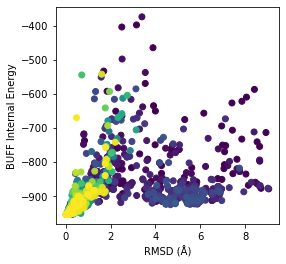

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('d_CC-Di-A17_ap-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-836.019	71.2072	-925.513	-580.665
1  	100  	-865.514	40.4981	-938.429	-653.341
2  	100  	-880.189	24.3126	-938.429	-817.338
3  	100  	-888.009	21.7874	-938.429	-824.395
4  	100  	-894.747	19.767 	-938.429	-836.133
5  	100  	-900.887	19.4281	-945.949	-836.133
6  	100  	-906.576	18.0315	-945.949	-862.444
7  	100  	-911.341	17.5446	-945.949	-862.444
8  	100  	-917.367	16.4335	-966.563	-879.019
9  	100  	-920.744	14.9004	-966.563	-887.645
10 	100  	-923.93 	14.8419	-966.563	-887.645
11 	100  	-927.303	14.1048	-966.563	-903.453
12 	100  	-931.989	14.8172	-968.166	-903.453
13 	100  	-935.421	14.1003	-968.166	-903.754
14 	100  	-938.028	13.311 	-968.166	-903.754
15 	100  	-942.588	11.6976	-968.166	-903.754
16 	100  	-945.737	9.94721	-968.166	-916.035
17 	100  	-948.315	9.46573	-971.246	-916.434
18 	100  	-950.905	7.98741	-971.246	-931.327
19 	100  	-953.537	7.93425	-971.246	-934.493
20 	100  	-955.296	7.60504	-971.246	-934.493
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-972.3511538619546

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

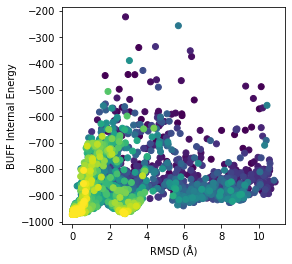

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('d_CC-Di-A17_ap-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min    	max     
0  	100  	-728.841	164.324	-933.13	-230.592
1  	72   	-681.206	191.733	-939.777	-105.036
2  	54   	-698.325	217.155	-939.777	-105.036
3  	43   	-714.893	200.275	-939.777	-111.572
4  	62   	-787.446	142.632	-939.777	-201.696
5  	60   	-775.213	138.663	-950.489	-456.806
6  	65   	-787.117	114.134	-950.489	-456.806
7  	88   	-784.937	102.181	-921.39 	-441.406
8  	88   	-766.637	153.141	-947.135	-289.673
9  	59   	-808.543	131.046	-952.67 	-289.673
10 	41   	-820.331	114.853	-952.67 	-439.721
11 	54   	-820.665	108.832	-952.67 	-439.721
12 	78   	-846.204	78.8472	-946    	-500.8  
13 	77   	-793.079	151.342	-946    	-220.239
14 	67   	-768.776	163.002	-933.167	-220.239
15 	59   	-758.482	182.165	-935.558	132.349 
16 	67   	-770.951	180.424	-948.385	132.349 
17 	66   	-810.748	110.073	-941.056	-333.65 
18 	75   	-837.929	80.0085	-941.056	-535.758
19 	51   	-837.051	82.6469	-941.056	-520.551
20 	37   	-830.571	90.1664	-940.843	-484.356
21 	67   	-7

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-952.6699010991257

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

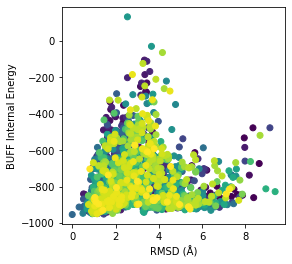

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('d_CC-Di-A17_ap-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-771.559	84.6853	-927.011	-508.856
1  	100  	-811.527	79.1617	-930.225	-411.87 
2  	100  	-816.202	90.0039	-918.649	-406.393
3  	100  	-849.373	54.998 	-926.107	-570.319
4  	100  	-838.724	79.057 	-931.76 	-559.438
5  	100  	-866.105	64.6343	-923.064	-400.498
6  	100  	-876.351	75.0572	-941.467	-291.914
7  	100  	-880.538	38.2028	-929.135	-690.879
8  	100  	-891.037	41.6663	-928.679	-671.607
9  	100  	-892.042	53.1081	-929.39 	-476.02 
10 	100  	-912.512	11.051 	-929.079	-888.218
11 	100  	-911.871	18.3733	-930.215	-812.641
12 	100  	-919.119	9.86825	-930.753	-886.986
13 	100  	-922.69 	10.2262	-932.373	-854.614
14 	100  	-921.812	15.837 	-932.434	-816.109
15 	100  	-925.176	8.72573	-933.006	-882.022
16 	100  	-925.068	10.17  	-933.52 	-883.271
17 	100  	-926.375	12.1147	-934.625	-858.61 
18 	100  	-917.865	26.093 	-935.117	-738.589
19 	100  	-925.311	16.9108	-935.823	-861.05 
20 	100  	-922.316	18.5415	-936.842	-869.786
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-941.4674579147347

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

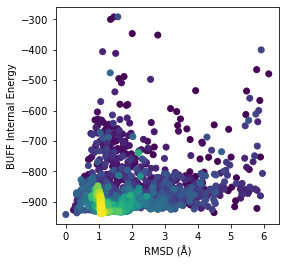

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('d_CC-Di-A17_ap-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)